In [7]:
%load_ext autoreload
%autoreload
%matplotlib widget
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
importlib.reload(pc)
import ipywidgets as widgets
from IPython.display import display



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_title = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_title, species))
# Get first anolis
wf = wf_list[0][0]
fs = wf_list[0][1]
wf_title = wf_list[0][2]
del df

Loading Curated Data
Combining into one Dataframe!


In [18]:
"Calculate species comparison"

# Set parameters
tauS = 2**11
tau = tauS / 44100 # Everyone uses the same tau
min_xi = 0.0025
max_xi = tau
base_num_xis = 50

# Set if we use the below defined rho or the fwhm
dynamic_windowing = True
rho = 10 # For dynamic windowing
fwhm = max_xi # For fixed windowing

if dynamic_windowing:
    rho = rho
    fwhm = None
    pkl_fn = f'species_coherences_list_rho{rho}'
else:
    rho = None
    fwhm = fwhm
    pkl_fn = f'species_coherences_list_fwhm{fwhm:.5f}'

species_coherences_list = []
for j, (wf, fs, wf_title, species) in enumerate(wf_list):    
    # Make species adjustments
    match species:
        case 'Anolis':
            max_xi = tau # Tau seems to be long enough for the lizards
            num_xis = base_num_xis
        case 'Owl':
            max_xi = tau * 2 # Go out a bit farther for owls
            num_xis = base_num_xis * 2 # Double xi resolution to compensate
        case 'Human':
            max_xi = tau * 32 # Go out way farther for humans
            num_xis = base_num_xis * 8 # Up the xi resolution a bit to compensate
        
    if fs != 44100: # Prioritize tau homogenity with other species over ideal tauS = 2**N
        tauS = int(tau * fs)
        
    # Calculate xi and frequency arrays
    xis = np.linspace(min_xi, max_xi, num_xis)
    f = rfftfreq(tauS, 1/fs)
    
    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
    max_xiS = max(xis) * fs
    N_segs = int((len(wf) - tauS) / max_xiS)    
    
    # Initialize coherences array
    coherences = np.zeros((len(f), len(xis)))
    # Calculate coherences
    for i, xi in enumerate(xis):
        print(f"Calculating xi {i+1}/{len(xis)} for wf {j+1}/{len(wf_list)}")
        if dynamic_windowing:
            coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, N_segs=N_segs, rho=rho)[1]
        else:
            raise NotImplementedError
        
    # Add to list
    species_coherences_list.append((coherences, f, xis, tau, wf_title, species))


with open(pkl_fn + '.pkl', 'wb') as f:
    pickle.dump(species_coherences_list, f)
    

Calculating xi 1/50 for wf 1/9
Calculating xi 2/50 for wf 1/9
Calculating xi 3/50 for wf 1/9
Calculating xi 4/50 for wf 1/9
Calculating xi 5/50 for wf 1/9
Calculating xi 6/50 for wf 1/9
Calculating xi 7/50 for wf 1/9
Calculating xi 8/50 for wf 1/9
Calculating xi 9/50 for wf 1/9
Calculating xi 10/50 for wf 1/9
Calculating xi 11/50 for wf 1/9
Calculating xi 12/50 for wf 1/9
Calculating xi 13/50 for wf 1/9
Calculating xi 14/50 for wf 1/9
Calculating xi 15/50 for wf 1/9
Calculating xi 16/50 for wf 1/9
Calculating xi 17/50 for wf 1/9
Calculating xi 18/50 for wf 1/9
Calculating xi 19/50 for wf 1/9
Calculating xi 20/50 for wf 1/9
Calculating xi 21/50 for wf 1/9
Calculating xi 22/50 for wf 1/9
Calculating xi 23/50 for wf 1/9
Calculating xi 24/50 for wf 1/9
Calculating xi 25/50 for wf 1/9
Calculating xi 26/50 for wf 1/9
Calculating xi 27/50 for wf 1/9
Calculating xi 28/50 for wf 1/9
Calculating xi 29/50 for wf 1/9
Calculating xi 30/50 for wf 1/9
Calculating xi 31/50 for wf 1/9
Calculating xi 32

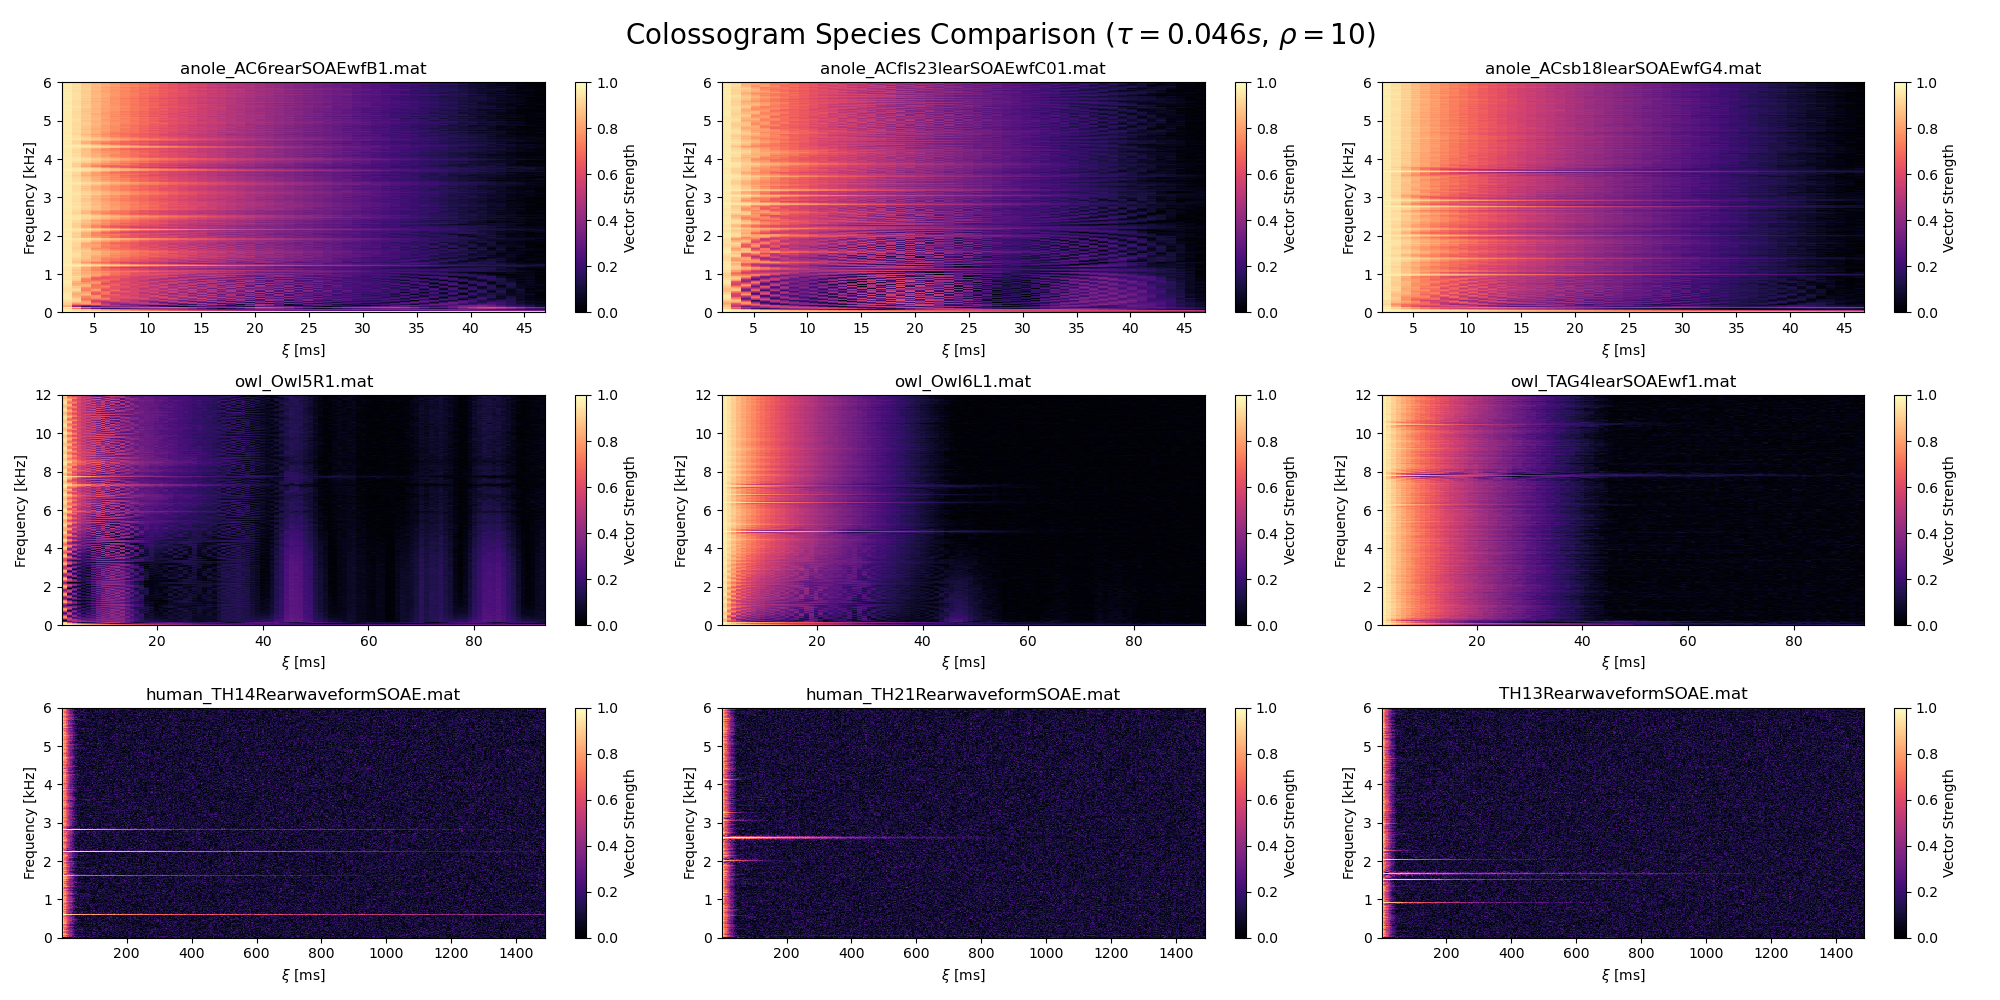

In [19]:
"Plot different species comparison"
   
cmap = 'magma'
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (coherences, f, xis, tau, wf_title, species) in enumerate(species_coherences_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    else:
        max_khz = 6
    plot_colossogram(coherences, f, xis, tau, title=wf_title, max_khz=max_khz, cmap=cmap)

if dynamic_windowing:
    suptitle = rf'Colossogram Species Comparison ($\tau={tau:.3f}s$, $\rho = {rho}$)'
    filename = rf'colossogram species comparison (tau={tau:.3f}, rho={rho})'
else:
    suptitle = rf'Colossogram Species Comparison ($\tau={tau:.3f}s$, $FWHM={fwhm:.5f}s$)'
    filename = rf'colossogram species comparison (tau={tau:.3f}, FWHM={fwhm:.5f})'

plt.suptitle(suptitle, fontsize=20)
plt.tight_layout()
plt.savefig(filename + '.png', dpi=300)
plt.show()

In [ ]:
"Basic Colossogram calculations"
tauS = 2**11
tau = tauS / fs
xis = np.linspace(0.0025, tau, 30)
max_xiS = max(xis) * fs
f = rfftfreq(tauS, 1/fs)
# Make sure we have a consistent number of segments to take vector strenght over since this will change with xi
N_segs = int((len(wf) - tauS) / max_xiS)    


In [ ]:
"Basic Plot"
rho = None
coherences = np.zeros((len(f), len(xis)))
for i, xi in enumerate(xis):
    coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
    
plt.figure(figsize=(12, 6))
plot_colossogram(coherences, f, xis, tau, wf_title=wf_title)
plt.show()

In [ ]:
"Rho Plot"
rho = 1
coherences_rho = np.zeros((len(f), len(xis)))
for i, xi in enumerate(xis):
    coherences_rho[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
plt.figure(figsize=(12, 6))
plot_colossogram(coherences, f, xis, tau, wf_title=wf_title)
plt.suptitle('$\rho = 1$')
plt.show()

In [ ]:
"Sigma Plot"
coherences_sigma = np.zeros((len(f), len(xis)))
sigma = tau / 10
for i, xi in enumerate(xis):
    coherences_sigma[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, win_type=("gauss", sigma * fs))[1]
plt.figure(figsize=(12, 6))
plot_colossogram(coherences, f, xis, tau, wf_title=wf_title)
plt.suptitle(rf'$Constant \sigma = {sigma:.5f}$')
plt.show()

In [ ]:
"Calculate sigma comparison"
sigma_coherences_list = []
tauS = 2**11
tau = tauS / 44100
xis = np.linspace(0.0025, tau, 30)
sigmas = np.linspace(0.0025/4, tau/8, 9)
for i, sigma in enumerate(sigmas):
    coherences = np.zeros((len(f), len(xis)))
    for j, xi in enumerate(xis):
        coherences[:, j] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, win_type=("gauss", sigma * fs))[1]
    sigma_coherences_list.append((sigma, coherences))

In [ ]:
"Plot sigma comparison"
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (sigma, coherences) in enumerate(sigma_coherences_list):
    plt.subplot(3, 3, i + 1)
    plot_colossogram(coherences, f, xis, tau, wf_title=rf'$\sigma={sigma:.5f}$')
plt.suptitle(rf'Colossogram $\sigma$ comparison ($\tau={tau:.3f}$, {wf_title})')
plt.tight_layout()
plt.savefig(rf'Colossogram sigma comparison.png', dpi=300)
plt.show()

In [ ]:
"Calculate rho comparison"
sigma_coherences_list = []
tauS = 2**11
tau = tauS / 44100
xis = np.linspace(0.0025, tau, 30)
rhos = [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 3, 5]
for i, rho in enumerate(rhos):
    coherences = np.zeros((len(f), len(xis)))
    for j, xi in enumerate(xis):
        coherences[:, j] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
    sigma_coherences_list.append((rho, coherences))

In [ ]:
"Plot rho comparison"
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (rho, coherences) in enumerate(sigma_coherences_list):
    plt.subplot(3, 3, i + 1)
    plot_colossogram(coherences, f, xis, tau, wf_title=rf'$\rho={rho:.5f}$')
plt.suptitle(rf'Colossogram $\rho$ comparison ($\tau={tau:.3f}$, {wf_title})', fontsize=20)
plt.savefig(rf'Colossogram rho comparison.png', dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
"Calculate and plot species comparison (sigma=0.0025)"
sigma = 0.0025
sigmaS = sigma * fs
species_coherences_list = []
for wf, fs, wf_title, species in wf_list:
    tauS = 2**11
    tau = tauS / 44100 # Everyone uses the same tau
    xis = np.linspace(0.0025, tau, 50) # And xis
    if fs != 44100: # Prioritize homogenity with other species over ideal 2**N tau
        tauS = int(tau * fs)
    max_xiS = max(xis) * fs
    f = rfftfreq(tauS, 1/fs)
    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
    N_segs = int((len(wf) - tauS) / max_xiS)    
    coherences = np.zeros((len(f), len(xis)))
    for i, xi in enumerate(xis):
        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, win_type=("gauss", sigmaS))[1]
    species_coherences_list.append((coherences, f, xis, tau, wf_title, species))
    
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (coherences, f, xis, tau, wf_title, species) in enumerate(species_coherences_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    else:
        max_khz = 6
    plot_colossogram(coherences, f, xis, tau, wf_title=wf_title, max_khz=max_khz)
plt.suptitle(rf'Colossogram Species Comparison ($\tau={tau:.3f}$, $\sigma = {sigma}$)', fontsize=20)
plt.tight_layout()
plt.savefig(rf'Colossogram species comparison (sigma={sigma}).png', dpi=300)
plt.show()

In [ ]:
"Calculate and plot species comparison (no windowing)"
species_coherences_list = []
for wf, fs, wf_title, species in wf_list:
    tauS = 2**11
    tau = tauS / 44100 # Everyone uses the same tau
    xis = np.linspace(0.0025, tau, 50) # And xis
    if fs != 44100: # Prioritize homogenity with other species over ideal 2**N tau
        tauS = int(tau * fs)
    max_xiS = max(xis) * fs
    f = rfftfreq(tauS, 1/fs)
    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
    N_segs = int((len(wf) - tauS) / max_xiS)    
    coherences = np.zeros((len(f), len(xis)))
    for i, xi in enumerate(xis):
        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs)[1]
    species_coherences_list.append((coherences, f, xis, tau, wf_title, species))
    
plt.close('all')
plt.figure(figsize=(20, 10))
for i, (coherences, f, xis, tau, wf_title, species) in enumerate(species_coherences_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    else:
        max_khz = 6
    plot_colossogram(coherences, f, xis, tau, wf_title=wf_title, max_khz=max_khz)
plt.suptitle(rf'Colossogram Species Comparison ($\tau={tau:.3f}$, No Windowing)', fontsize=20)
plt.tight_layout()
plt.savefig(rf'Colossogram species comparison (no windowing).png', dpi=300)
plt.show()

In [ ]:
"Calculate and plot PSD species comparison"
species_psd_list = []
tau = 2**11 / 44100

for wf, fs, wf_title, species in wf_list:
    species_psd_list.append((get_welch(wf=wf, fs=fs, tau=tau, scaling="density"), wf_title, species))
    
plt.close('all')
plt.figure(figsize=(20, 10))
for i, ((f, psd), wf_title, species) in enumerate(species_psd_list):
    plt.subplot(3, 3, i + 1)
    if species == "Owl":
        max_khz = 12
    else:
        max_khz = 6
    plt.plot(f/1000, 10*np.log10(psd))
    # plt.plot(f/1000, (psd))
    plt.xlim(0, max_khz)
    plt.ylim(-130, -60)
    # plt.ylim(0, 1e-8)
    plt.title(wf_title)
    plt.xlabel("Frequency [kHz]")
    plt.ylabel("PSD")
plt.suptitle(rf'PSD Species Comparison ($\tau={tau:.3f}$, No Windowing)', fontsize=20)
plt.tight_layout()
plt.savefig(rf'PSD species comparison (dB).png', dpi=300)
plt.show()